In [1]:
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10, CIFAR100

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from PIL import Image #图片显示
from collections import OrderedDict
import time as time
import numpy as np
import random
import matplotlib.pyplot as plt


In [2]:
import augmented
from augmented.cutmix import cutmix,CutMixCollator,CutMixCriterion,CutMix
from augmented.cutout import Cutout
from augmented.mixup import mixup_data,mixup_criterion

In [17]:
from torch.utils.tensorboard import SummaryWriter


In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    print("warning: CUDA is not available, using CPU instead")


# 1.绘制图像

In [8]:
#显示指定三张图像
def plotsample(data):
    fig, axs = plt.subplots(1,3,figsize=(10,10)) #建立子图
    for i in [0,1,2]:
        npimg = torchvision.utils.make_grid(data[i][0]).numpy() #提取图像
        #将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
        axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
        axs[i].axis("off") #消除每个子图的坐标轴

In [4]:
train_data = torchvision.datasets.CIFAR100(root = r"D:\university\computer\DeepLearning\data\cifar"
                                   ,train=True
                                   ,download=False
                                   ,transform = transforms.ToTensor())

In [6]:
#cutmix
cutmix_train =CutMix(train_data, num_class=100, beta=1.0, prob=1.0, num_mix=1) 

In [6]:
draw = torch.utils.data.Subset(train_data,[0,1,2])

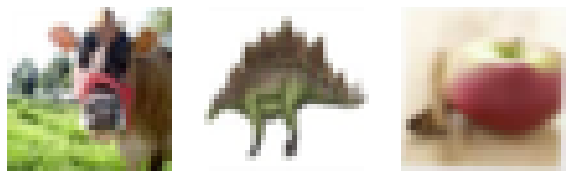

In [7]:
#原始图像
plotsample(draw)

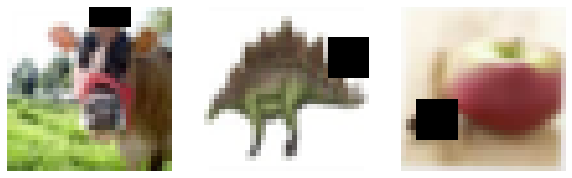

In [8]:
#cutout
#随机生成一个8*8的全黑像素块
cutout = Cutout(n_holes=1,length=8)
draw_cutout = DataLoader(dataset=draw,batch_size=1,shuffle=False)

fig, axs = plt.subplots(1,3,figsize=(10,10)) 
i = -1
for input,target in draw_cutout:
    i += 1
    input = input.to(device)
    input = cutout(input)
    input = input.cpu()
    npimg = torchvision.utils.make_grid(input).numpy() #提取图像
    #将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
    axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
    axs[i].axis("off") #消除每个子图的坐标轴
    


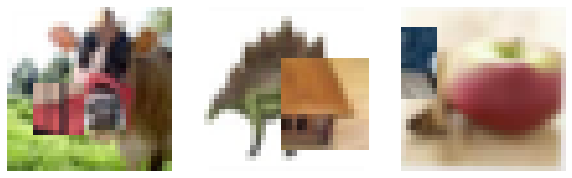

In [205]:
#cutmix
#CutMix的所选取的正方形区域在训练图像之间剪切和粘贴，真实标签值也按patches的面积比例混合
#alpha=1.0 
plotsample(cutmix_train)

In [204]:
#mixup
#Mixup将两个图像根据透明度混淆在一起
draw = torch.utils.data.Subset(train_data,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

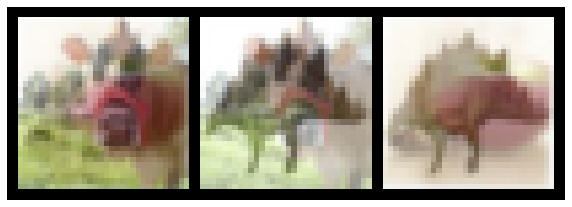

In [25]:
draw_mixup = DataLoader(dataset=draw,batch_size=3,shuffle=False)

fig, axs = plt.subplots(1,1,figsize=(10,10)) 
i = -1
for input,target in draw_mixup:
    i += 1
    input, targets_a, targets_b, lam = mixup_data(input, target,0.5)
    input = input.cpu()
    npimg = torchvision.utils.make_grid(input).numpy() #提取图像
    #将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
    axs.imshow(np.transpose(npimg, (1, 2, 0))) 
    axs.axis("off") #消除每个子图的坐标轴
    break

# 2.载入数据

+ baseline,cutout,mixup

In [4]:
#CIFAR100
train_data = torchvision.datasets.CIFAR100(root = r"D:\university\computer\DeepLearning\data\cifar"
                                   ,train=True
                                   ,download=False
                                   ,transform = transforms.Compose([
                                        transforms.Resize((32, 32)) 
                                       ,transforms.ToTensor() 
                                       ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                           ])
                                    )
                                           

In [5]:
test_data = torchvision.datasets.CIFAR100(root = r"D:\university\computer\DeepLearning\data\cifar"
                                   ,train=False
                                   ,download=False
                                   ,transform = transforms.Compose([
                                        transforms.Resize((32, 32))
                                       ,transforms.ToTensor() 
                                       ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                           ])
                                    )
                                         

In [6]:
print(len(train_data),len(test_data))

50000 10000


In [7]:
torch.manual_seed(100)  

batch_size = 128

train_loader = DataLoader(dataset=train_data
                                     ,batch_size=batch_size
                                     ,shuffle=True)
test_loader = DataLoader(dataset=test_data
                                     ,batch_size=batch_size
                                     ,shuffle=True)

In [8]:
print(len(train_data), len(train_data)/batch_size)
print(len(test_data), len(test_data)/batch_size)

50000 390.625
10000 78.125


+ cutmix

In [3]:

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_data = torchvision.datasets.CIFAR100(root = r"D:\university\computer\DeepLearning\data\cifar"
                                   ,train=True
                                   ,download=False
                                   ,transform = train_transform 
                                    )
test_data = torchvision.datasets.CIFAR100(root = r"D:\university\computer\DeepLearning\data\cifar"
                                   ,train=False
                                   ,download=False
                                   ,transform = transforms.Compose([
                                        transforms.Resize((32, 32))
                                       ,transforms.ToTensor() 
                                       ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                           ])
                                    )
                                           
collator = CutMixCollator(alpha=1)

In [4]:
torch.manual_seed(100)  
batch_size = 128
train_loader = DataLoader(dataset=train_data
                                     ,batch_size=batch_size
                                     ,shuffle=True
                                     ,collate_fn=collator
                                     ,pin_memory=True
                                     ,drop_last=True)
test_loader = DataLoader(dataset=test_data
                                     ,batch_size=batch_size
                                     ,shuffle=True)

cutmix训练前需要改数据，其他的都不需要

# 3.训练与测试

## baseline模型训练

+ 网络构建

In [23]:
#定义网络
model = resnet18(pretrained=False,num_classes=100).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 50
batches_show = 100
loss_history = []
accuracy_history = []
accuracy_batch = 0.0

In [24]:
writer = SummaryWriter('./logs')

In [26]:
i=0
for epoch in range(epochs):
    model.train()
    print("-------------------  TRAINING  -------------------")
    loss_train = 0.0
    running_loss = 0.0
    acc_train = 0.0
    running_acc = 0.0
    for batch, data in enumerate(train_loader, 1): #enumerate(sequence, [start=0])
        img, label = data[0].to(device), data[1].to(device)
        optimizer.zero_grad() #复位优化器梯度
        pred = model(img)    
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step() #反向迭代
        
        #记录训练过程中的损失值
        loss_history.append(loss.item())
        #记录训练过程中的准确率
        number_batch = label.size()[0] #图片个数
        _,predicted = torch.max(pred.data,dim=1)
        correct_batch = (predicted==label).sum().item()
        accuracy_batch = 100*correct_batch/number_batch
        accuracy_history.append(accuracy_batch)
        i+=1
        writer.add_scalar("loss",loss.item(),i)
        writer.add_scalar("acc",accuracy_batch,i)

        if batch % batches_show == 0:
            print('epoch {} batch {} In {} loss = {:.4f} accuracy = {:.4f}%'.format(epoch, batch , len(train_data)/batch_size, loss.item(), accuracy_batch)) 

    print("final loss =", loss.item())    
    print("final accu ={:.2f}%".format(accuracy_batch))

-------------------  TRAINING  -------------------
epoch 0 batch 100 In 390.625 loss = 3.9377 accuracy = 13.2812%
epoch 0 batch 200 In 390.625 loss = 3.7705 accuracy = 15.6250%
epoch 0 batch 300 In 390.625 loss = 3.1207 accuracy = 24.2188%
final loss = 3.0570216178894043
final accu =28.75%
-------------------  TRAINING  -------------------
epoch 1 batch 100 In 390.625 loss = 2.9934 accuracy = 28.1250%
epoch 1 batch 200 In 390.625 loss = 2.8855 accuracy = 22.6562%
epoch 1 batch 300 In 390.625 loss = 2.6668 accuracy = 33.5938%
final loss = 2.817636013031006
final accu =28.75%
-------------------  TRAINING  -------------------
epoch 2 batch 100 In 390.625 loss = 2.5618 accuracy = 33.5938%
epoch 2 batch 200 In 390.625 loss = 2.7909 accuracy = 27.3438%
epoch 2 batch 300 In 390.625 loss = 2.4995 accuracy = 36.7188%
final loss = 2.7211310863494873
final accu =32.50%
-------------------  TRAINING  -------------------
epoch 3 batch 100 In 390.625 loss = 2.2337 accuracy = 41.4062%
epoch 3 batch 

final loss = 0.0015616645105183125
final accu =100.00%
-------------------  TRAINING  -------------------
epoch 28 batch 100 In 390.625 loss = 0.0007 accuracy = 100.0000%
epoch 28 batch 200 In 390.625 loss = 0.0009 accuracy = 100.0000%
epoch 28 batch 300 In 390.625 loss = 0.0010 accuracy = 100.0000%
final loss = 0.0010922652436420321
final accu =100.00%
-------------------  TRAINING  -------------------
epoch 29 batch 100 In 390.625 loss = 0.0010 accuracy = 100.0000%
epoch 29 batch 200 In 390.625 loss = 0.0007 accuracy = 100.0000%
epoch 29 batch 300 In 390.625 loss = 0.0011 accuracy = 100.0000%
final loss = 0.000845148810185492
final accu =100.00%
-------------------  TRAINING  -------------------
epoch 30 batch 100 In 390.625 loss = 0.0010 accuracy = 100.0000%
epoch 30 batch 200 In 390.625 loss = 0.0011 accuracy = 100.0000%
epoch 30 batch 300 In 390.625 loss = 0.0288 accuracy = 99.2188%
final loss = 0.0007375901332125068
final accu =100.00%
-------------------  TRAINING  -------------

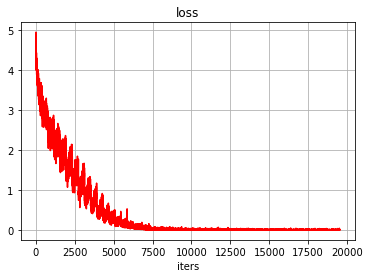

In [11]:
##显示loss的历史数据
plt.grid()
plt.xlabel("iters")
plt.ylabel("")
plt.title("loss", fontsize = 12)
plt.plot(loss_history, "r")
plt.show()

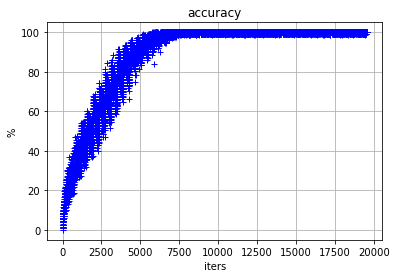

In [12]:
#显示准确率的历史数据
plt.grid()
plt.xlabel("iters")
plt.ylabel("%")
plt.title("accuracy", fontsize = 12)
plt.plot(accuracy_history, "b+")
plt.show()

In [13]:
#清除不在使用的GPU内存
torch.cuda.empty_cache()

+ 测试集验证

In [16]:
model.eval()
correct_dataset  = 0
total_dataset    = 0
accuracy_dataset = 0.0
print("------------------- EVALUATING -------------------")
with torch.no_grad():
    for batch, data in enumerate(test_loader, 1):
        img, label = data[0].to(device), data[1].to(device)
        pred = model(img)
        _,predicted = torch.max(pred.data,dim=1)

        #对batch中的样本数进行累计
        total_dataset += label.size()[0] 
        
        #对batch中的所有结果进行比较"
        bool_results = (predicted == label)
        
        #统计预测正确样本的个数
        correct_dataset += bool_results.sum().item()
        
        #统计预测正确样本的精度
        accuracy_dataset = 100 * correct_dataset/total_dataset
        
#         if(i % 100 == 0):
#             print('batch {} In {} accuracy = {:.4f}'.format(i, len(test_data)/64, accuracy_dataset))
            
print('Final result with the model on the dataset, accuracy =', accuracy_dataset)


------------------- EVALUATING -------------------
Final result with the model on the dataset, accuracy = 44.07


In [ ]:
#存储模型
torch.save(model, "./models/resnet_cifar100_original.pkl")
 
#存储参数
torch.save(model.state_dict() , "./models/resnet_params_cifar100__original.pkl")

## Cutout模型训练

In [55]:
#定义网络
model = resnet18(pretrained=False,num_classes=100).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 50
batches_show = 100
loss_history = []
accuracy_history = []
accuracy_batch = 0.0

cutout = Cutout(n_holes=1,length=8)

In [56]:
for epoch in range(epochs):
    model.train()
    print("-------------------  TRAINING  -------------------")
    loss_train = 0.0
    running_loss = 0.0
    acc_train = 0.0
    running_acc = 0.0
    for batch, data in enumerate(train_loader, 1): 
        img, label = data[0].to(device), data[1].to(device)
        img = cutout(img)
        optimizer.zero_grad() #复位优化器梯度
        pred = model(img)    
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step() #反向迭代
        
        #记录训练过程中的损失值
        loss_history.append(loss.item())
        #记录训练过程中的准确率
        number_batch = label.size()[0] #图片个数
        _,predicted = torch.max(pred.data,dim=1)
        correct_batch = (predicted==label).sum().item()
        accuracy_batch = 100*correct_batch/number_batch
        accuracy_history.append(accuracy_batch)


        if batch % batches_show == 0:
            print('epoch {} batch {} In {} loss = {:.4f} accuracy = {:.4f}%'.format(epoch, batch , len(train_data)/batch_size, loss.item(), accuracy_batch)) 

    print("final loss =", loss.item())    
    print("final accu ={:.2f}%".format(accuracy_batch))
    


-------------------  TRAINING  -------------------
epoch 0 batch 100 In 390.625 loss = 3.8550 accuracy = 10.9375%
epoch 0 batch 200 In 390.625 loss = 3.6211 accuracy = 17.9688%
epoch 0 batch 300 In 390.625 loss = 3.4558 accuracy = 16.4062%
final loss = 3.411452531814575
final accu =16.25%
-------------------  TRAINING  -------------------
epoch 1 batch 100 In 390.625 loss = 3.0540 accuracy = 25.7812%
epoch 1 batch 200 In 390.625 loss = 3.1903 accuracy = 22.6562%
epoch 1 batch 300 In 390.625 loss = 2.8926 accuracy = 28.9062%
final loss = 2.9832096099853516
final accu =32.50%
-------------------  TRAINING  -------------------
epoch 2 batch 100 In 390.625 loss = 2.6003 accuracy = 34.3750%
epoch 2 batch 200 In 390.625 loss = 2.5853 accuracy = 31.2500%
epoch 2 batch 300 In 390.625 loss = 2.5983 accuracy = 28.9062%
final loss = 2.413186550140381
final accu =37.50%
-------------------  TRAINING  -------------------
epoch 3 batch 100 In 390.625 loss = 2.3271 accuracy = 33.5938%
epoch 3 batch 2

epoch 28 batch 100 In 390.625 loss = 0.0725 accuracy = 97.6562%
epoch 28 batch 200 In 390.625 loss = 0.0446 accuracy = 100.0000%
epoch 28 batch 300 In 390.625 loss = 0.1306 accuracy = 93.7500%
final loss = 0.1798684448003769
final accu =93.75%
-------------------  TRAINING  -------------------
epoch 29 batch 100 In 390.625 loss = 0.0392 accuracy = 99.2188%
epoch 29 batch 200 In 390.625 loss = 0.2027 accuracy = 92.1875%
epoch 29 batch 300 In 390.625 loss = 0.1995 accuracy = 95.3125%
final loss = 0.09814678132534027
final accu =96.25%
-------------------  TRAINING  -------------------
epoch 30 batch 100 In 390.625 loss = 0.0563 accuracy = 98.4375%
epoch 30 batch 200 In 390.625 loss = 0.1410 accuracy = 94.5312%
epoch 30 batch 300 In 390.625 loss = 0.0803 accuracy = 98.4375%
final loss = 0.30305013060569763
final accu =85.00%
-------------------  TRAINING  -------------------
epoch 31 batch 100 In 390.625 loss = 0.1918 accuracy = 92.1875%
epoch 31 batch 200 In 390.625 loss = 0.1679 accurac

+ 测试集验证

In [57]:
model.eval()
correct_dataset  = 0
total_dataset    = 0
accuracy_dataset = 0.0
print("------------------- EVALUATING -------------------")
with torch.no_grad():
    for batch, data in enumerate(test_loader, 1):
        img, label = data[0].to(device), data[1].to(device)
        pred = model(img)
        _,predicted = torch.max(pred.data,dim=1)

        #对batch中的样本数进行累计
        total_dataset += label.size()[0] 
        
        #对batch中的所有结果进行比较"
        bool_results = (predicted == label)
        
        #统计预测正确样本的个数
        correct_dataset += bool_results.sum().item()
        
        #统计预测正确样本的精度
        accuracy_dataset = 100 * correct_dataset/total_dataset
        
#         if(i % 10 == 0):
#             print('batch {} In {} accuracy = {:.4f}'.format(i, len(test_data)/64, accuracy_dataset))
            
print('Final result with the model on the dataset, accuracy =', accuracy_dataset)


------------------- EVALUATING -------------------
Final result with the model on the dataset, accuracy = 44.33


In [58]:
#存储模型
torch.save(model, "./models/resnet_cifar100_cutout.pkl")
 
#存储参数
torch.save(model.state_dict() , "./models/resnet_params_cifar100__cutout.pkl")

## Mixup 模型训练

In [60]:
#定义网络
model = resnet18(pretrained=False,num_classes=100).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(device)
epochs = 50
batches_show = 100
loss_history = []
accuracy_history = []
accuracy_batch = 0.0



In [61]:
for epoch in range(epochs):
    model.train()
    print("-------------------  TRAINING  -------------------")
    loss_train = 0.0
    running_loss = 0.0
    acc_train = 0.0
    running_acc = 0.0
    for batch, data in enumerate(train_loader, 1): 
        img, label = data[0].to(device), data[1].to(device)
        img, targets_a, targets_b, lam = mixup_data(img, label,0.5)
        img, targets_a, targets_b = map(Variable, (img,targets_a, targets_b))
        
        optimizer.zero_grad() #复位优化器梯度
        pred = model(img)    
        loss = mixup_criterion(criterion, pred, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step() #反向迭代
        
        #记录训练过程中的损失值
        loss_history.append(loss.item())
        #记录训练过程中的准确率
        number_batch = label.size()[0] #图片个数
        _,predicted = torch.max(pred.data,dim=1)
        correct_batch = (predicted==label).sum().item()
        accuracy_batch = 100*correct_batch/number_batch
        accuracy_history.append(accuracy_batch)


        if batch % batches_show == 0:
            print('epoch {} batch {} In {} loss = {:.4f} accuracy = {:.4f}%'.format(epoch, batch , len(train_data)/batch_size, loss.item(), accuracy_batch)) 

    print("final loss =", loss.item())    
    print("final accu ={:.2f}%".format(accuracy_batch))
    


-------------------  TRAINING  -------------------
epoch 0 batch 100 In 390.625 loss = 4.3684 accuracy = 10.1562%
epoch 0 batch 200 In 390.625 loss = 3.9287 accuracy = 0.0000%
epoch 0 batch 300 In 390.625 loss = 3.3853 accuracy = 24.2188%
final loss = 3.4539244174957275
final accu =2.50%
-------------------  TRAINING  -------------------
epoch 1 batch 100 In 390.625 loss = 3.3343 accuracy = 0.0000%
epoch 1 batch 200 In 390.625 loss = 3.5500 accuracy = 0.7812%
epoch 1 batch 300 In 390.625 loss = 3.8627 accuracy = 17.9688%
final loss = 4.115629196166992
final accu =15.00%
-------------------  TRAINING  -------------------
epoch 2 batch 100 In 390.625 loss = 3.2118 accuracy = 25.7812%
epoch 2 batch 200 In 390.625 loss = 3.1550 accuracy = 27.3438%
epoch 2 batch 300 In 390.625 loss = 3.1348 accuracy = 1.5625%
final loss = 2.847837209701538
final accu =28.75%
-------------------  TRAINING  -------------------
epoch 3 batch 100 In 390.625 loss = 2.5706 accuracy = 41.4062%
epoch 3 batch 200 In

epoch 28 batch 100 In 390.625 loss = 3.1314 accuracy = 41.4062%
epoch 28 batch 200 In 390.625 loss = 0.4915 accuracy = 99.2188%
epoch 28 batch 300 In 390.625 loss = 0.3015 accuracy = 99.2188%
final loss = 1.5877761840820312
final accu =96.25%
-------------------  TRAINING  -------------------
epoch 29 batch 100 In 390.625 loss = 3.3987 accuracy = 28.9062%
epoch 29 batch 200 In 390.625 loss = 3.3262 accuracy = 21.0938%
epoch 29 batch 300 In 390.625 loss = 2.2373 accuracy = 81.2500%
final loss = 0.28617358207702637
final accu =3.75%
-------------------  TRAINING  -------------------
epoch 30 batch 100 In 390.625 loss = 0.1736 accuracy = 99.2188%
epoch 30 batch 200 In 390.625 loss = 0.1053 accuracy = 99.2188%
epoch 30 batch 300 In 390.625 loss = 0.1376 accuracy = 1.5625%
final loss = 2.448728561401367
final accu =6.25%
-------------------  TRAINING  -------------------
epoch 31 batch 100 In 390.625 loss = 0.6203 accuracy = 100.0000%
epoch 31 batch 200 In 390.625 loss = 1.7553 accuracy = 9

+ 测试集验证

In [65]:
model.eval()
correct_dataset  = 0
total_dataset    = 0
accuracy_dataset = 0.0
print("------------------- EVALUATING -------------------")
with torch.no_grad():
    for batch, data in enumerate(test_loader, 1):
        img, label = data[0].to(device), data[1].to(device)
        pred = model(img)
        _,predicted = torch.max(pred.data,dim=1)

        #对batch中的样本数进行累计
        total_dataset += label.size()[0] 
        
        #对batch中的所有结果进行比较"
        bool_results = (predicted == label)
        
        #统计预测正确样本的个数
        correct_dataset += bool_results.sum().item()
        
        #统计预测正确样本的精度
        accuracy_dataset = 100 * correct_dataset/total_dataset
        
#         if(i % 10 == 0):
#             print('batch {} In {} accuracy = {:.4f}'.format(i, len(test_data)/64, accuracy_dataset))
            
print('Final result with the model on the dataset, accuracy =', accuracy_dataset)


------------------- EVALUATING -------------------
Final result with the model on the dataset, accuracy = 45.05


In [66]:
#存储模型
torch.save(model, "./models/resnet_cifar100_mixup.pkl")
 
#存储参数
torch.save(model.state_dict() , "./models/resnet_params_cifar100__mixup.pkl")

## Cutmix模型训练

In [7]:
#定义网络
#cutmix训练前要把dataloader改成cutmix过的数据
model = resnet18(pretrained=False,num_classes=100).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
criterion = CutMixCriterion(reduction='mean')
epochs = 50
batches_show = 100
loss_history = []
accuracy_history = []
accuracy_batch = 0.0


In [8]:
model.train()
device = torch.device("cuda")
for epoch in range(epochs):
    
    print("-------------------  TRAINING  -------------------")
    loss_train = 0.0
    running_loss = 0.0
    acc_train = 0.0
    running_acc = 0.0
    for batch, (data, targets) in enumerate(train_loader, 1): 
        data = data.to(device)
        if isinstance(targets, (tuple, list)):
            targets1,targets2,lam = targets
            targets = (targets1.to(device), targets2.to(device), lam)
        else:
            targets = targets.to(device)
        
        optimizer.zero_grad() #复位优化器梯度
        pred = model(data)    
        loss = criterion(pred, targets)
        loss.backward()
        optimizer.step() #反向迭代
        
        #记录训练过程中的损失值
        loss_history.append(loss.item())
        #记录训练过程中的准确率
        number_batch = data.size()[0] #图片个数
        _,predicted = torch.max(pred,dim=1)
        if isinstance(targets,(tuple,list)):
            targets1, targets2, lam = targets
            correct1 = predicted.eq(targets1).sum().item()
            correct2 = predicted.eq(targets2).sum().item()
            accuracy_batch = (lam * correct1 + (1 - lam) * correct2) /number_batch
        accuracy_history.append(accuracy_batch)


        if batch % batches_show == 0:
            print('epoch {} batch {} In {} loss = {:.4f} accuracy = {:.4f}%'.format(epoch, batch , len(train_data)/batch_size, loss.item(), accuracy_batch)) 
            
    print("final loss =", loss.item())    
    print("final accu ={:.2f}%".format(accuracy_batch))
    
    


-------------------  TRAINING  -------------------
epoch 0 batch 100 In 390.625 loss = 4.3339 accuracy = 0.0653%
epoch 0 batch 200 In 390.625 loss = 4.3970 accuracy = 0.0396%
epoch 0 batch 300 In 390.625 loss = 4.3133 accuracy = 0.0612%
final loss = 4.3980937004089355
final accu =0.06%
-------------------  TRAINING  -------------------
epoch 1 batch 100 In 390.625 loss = 4.2642 accuracy = 0.0513%
epoch 1 batch 200 In 390.625 loss = 3.9051 accuracy = 0.1139%
epoch 1 batch 300 In 390.625 loss = 4.2562 accuracy = 0.0757%
final loss = 4.135470867156982
final accu =0.07%
-------------------  TRAINING  -------------------
epoch 2 batch 100 In 390.625 loss = 4.0814 accuracy = 0.0976%
epoch 2 batch 200 In 390.625 loss = 4.1618 accuracy = 0.0921%
epoch 2 batch 300 In 390.625 loss = 4.1379 accuracy = 0.0612%
final loss = 4.060248851776123
final accu =0.06%
-------------------  TRAINING  -------------------
epoch 3 batch 100 In 390.625 loss = 4.1247 accuracy = 0.0714%
epoch 3 batch 200 In 390.625

epoch 28 batch 300 In 390.625 loss = 3.3726 accuracy = 0.2807%
final loss = 2.9429233074188232
final accu =0.33%
-------------------  TRAINING  -------------------
epoch 29 batch 100 In 390.625 loss = 3.5199 accuracy = 0.2037%
epoch 29 batch 200 In 390.625 loss = 3.7330 accuracy = 0.1599%
epoch 29 batch 300 In 390.625 loss = 3.6737 accuracy = 0.1567%
final loss = 3.607699155807495
final accu =0.15%
-------------------  TRAINING  -------------------
epoch 30 batch 100 In 390.625 loss = 3.5641 accuracy = 0.3068%
epoch 30 batch 200 In 390.625 loss = 2.2461 accuracy = 0.4493%
epoch 30 batch 300 In 390.625 loss = 3.3066 accuracy = 0.2189%
final loss = 3.9740371704101562
final accu =0.12%
-------------------  TRAINING  -------------------
epoch 31 batch 100 In 390.625 loss = 2.6796 accuracy = 0.4125%
epoch 31 batch 200 In 390.625 loss = 2.5192 accuracy = 0.3855%
epoch 31 batch 300 In 390.625 loss = 2.9970 accuracy = 0.3013%
final loss = 3.8851938247680664
final accu =0.13%
------------------

+ 测试集验证

In [9]:
model.eval()
correct_dataset  = 0
total_dataset    = 0
accuracy_dataset = 0.0
print("------------------- EVALUATING -------------------")
with torch.no_grad():
    for batch, data in enumerate(test_loader, 1):
        img, label = data[0].to(device), data[1].to(device)
        pred = model(img)
        _,predicted = torch.max(pred.data,dim=1)

        #对batch中的样本数进行累计
        total_dataset += label.size()[0] 
        
        #对batch中的所有结果进行比较"
        bool_results = (predicted == label)
        
        #统计预测正确样本的个数
        correct_dataset += bool_results.sum().item()
        
        #统计预测正确样本的精度
        accuracy_dataset = 100 * correct_dataset/total_dataset
        
#         if(i % 10 == 0):
#             print('batch {} In {} accuracy = {:.4f}'.format(i, len(test_data)/64, accuracy_dataset))
            
print('Final result with the model on the dataset, accuracy =', accuracy_dataset)


------------------- EVALUATING -------------------
Final result with the model on the dataset, accuracy = 49.38


In [10]:
#存储模型
torch.save(model, "./models/resnet_cifar100_cutmix.pkl")
 
#存储参数
torch.save(model.state_dict() , "./models/resnet_params_cifar100__cutmix.pkl")

## 读取模型

In [15]:
model = torch.load("./models/resnet_cifar100_original.pkl")